<a href="https://colab.research.google.com/github/sungjindo/black_coal_price/blob/main/Xgboost_blackcoal_all.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0.Module
 
- 파일은 prophet을 통해 각 feature의 예측값을 뽑아낸 뒤에 

xgboost를 통해서 Coal_price 값을 예측해보았다.

- 여기에 추가로 19년도 1월 1일 예측시점부터 하루씩 더해가며 recursive model을 구축하였다.

- model -> prophet 예측값 +xgboost(recursive)
- model -> prophet 예측값 +(t-1시점)Coal_price - predict값을 recursive

In [ ]:
# 기본 라이브러리
import pandas as pd
import numpy as np
import os

# 시각화 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns

from plotly.offline import init_notebook_mode, iplot #plotly offline mode 
init_notebook_mode(connected = True)
import plotly.graph_objs as go #plotly graphical object
%matplotlib notebook
%matplotlib inline

# 통계 및 기계학습 관련 라이브러리
from scipy import stats    # 통계 관련 라이브러리
from sklearn.model_selection import train_test_split, RandomizedSearchCV    # 데이터 셋 분류 라이브러리
from sklearn.utils import resample    # 데이터 업샘플링&다운샘플링 라이브러리
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTEENN    # 복합샘플링 라이브러리
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler    # 데이터 스케일링 라이브러리
from statsmodels.stats.outliers_influence import variance_inflation_factor    # 변수 간 다중공선성 확인(VIF) 라이브러리
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, plot_confusion_matrix, plot_roc_curve)    # 모델 정확도 검증 라이브러리
from sklearn.model_selection import cross_val_score, train_test_split   # validation  검증 라이브러리

import matplotlib.pyplot as plt
import matplotlib

import statsmodels.api as sm    # 통계분석 관련 라이브러리
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from fbprophet import Prophet


import warnings    # 경고문구 지우기
warnings.filterwarnings("ignore")

# xgboost라이브러리 추가
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from xgboost import XGBClassifier
from datetime import datetime

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#1.Data

*   df는 실제값으로 2018년도 12월 31일까지
*   df_pred는 prophet으로 prediction한 값 2019년부터 1월 1일까지 (Coal_price 제외)
*   df_merge에 예측에 필요한 coal_price값 제외하고 merge






In [ ]:
df = pd.read_excel("/content/gdrive/My Drive/Black_coal/data/dataset/project_dataset.xlsx")
df = df.sort_values('date')
df['date']= pd.to_datetime(df['date'])

df = df.set_index('date')
df = df[df.index < '2019-01-01']
df = df.reset_index()
df_pred = pd.read_csv("/content/gdrive/My Drive/Black_coal/data/dataset/prophet_pred/prophet_pred_final.csv", encoding = 'utf-8-sig')
df_pred = df_pred.rename(columns ={'ds':'date'})
df_pred['date']= pd.to_datetime(df_pred['date'])

df_pred = df_pred.set_index('date')
df_pred = df_pred.reset_index()
df_merge = pd.merge(df, df_pred, on=['date', 'Brent_fut', 'iron', 'copper_fut', 'WTI_fut', 'WTI', 'LNG_fut',
       'bdi', 'USD/AUD(호주)', 'USD/CAD(캐나다)', 'USD/COP(콜롬비아)', 'US 달러지수',
       'USD/IDR(인도네시아)', 'USD/RUB(러시아)', 'USD/ZAR(자메이카)', '상하이종합지수', '인도지수',
       '브라질지수', '다우존스지수', '프랑스지수', '영국지수', '독일지수', 'S&P500지수', '항셍지수', '나스닥지수',
       '코스피지수', '니케이225지수', '유로스톡스50지수', '호주지수', '캐나다지수'], how='outer')
       
df_merge = df_merge[['date', 'Coal_price', 'Brent_fut', 'iron', 'copper_fut', 'WTI_fut', 'WTI', 'LNG_fut',
       'bdi', 'USD/AUD(호주)', 'USD/CAD(캐나다)', 'USD/COP(콜롬비아)', 'US 달러지수',
       'USD/IDR(인도네시아)', 'USD/RUB(러시아)', 'USD/ZAR(자메이카)', '상하이종합지수', '인도지수',
       '브라질지수', '다우존스지수', '프랑스지수', '영국지수', '독일지수', 'S&P500지수', '항셍지수', '나스닥지수',
       '코스피지수', '니케이225지수', '유로스톡스50지수', '호주지수', '캐나다지수']]
df_merge['date']= pd.to_datetime(df_merge['date'])
df_drop = df_merge.drop('date',axis=1)
df_coal = pd.read_csv("/content/gdrive/My Drive/Black_coal/data/dataset/project_dataset.csv", encoding = 'utf-8-sig')
df_coal = df_coal.sort_values('date')
df_coal['date']= pd.to_datetime(df_coal['date'])

df_coal = df_coal.set_index('date')
df_coal = df_coal[df_coal.index < '2019-04-01']

df_coal = df_coal.reset_index()
df_coal = df_coal[['date','Coal_price']]

#2.Model

##2.1 recursive (1년 val)

*   30개 변수 prophe prediction 값 
*   y_pred값을 validation셋에 추가


In [ ]:
df_merge = df_merge.set_index('date')

In [ ]:
for i in range (89):
    
  
  # 학습과 테스트 데이터 분리
  split =  len(df_merge[:"2017-12-31"])
  split1 =  len(df_merge[:"2018-12-31"])
  
  df_train = df_drop[:split+i]
  df_test = df_drop[split+i:split1+i]
  df_predict = df_drop[len(df_merge[:"2018-12-31"]):len(df_merge[:"2019-01-01"])]

  df_train_y = df_train.loc[:,'Coal_price']
  df_train_x = df_train.drop('Coal_price', axis=1)
  df_test_y = df_test.loc[:,'Coal_price']
  df_test_x = df_test.drop('Coal_price', axis=1)
  # 나중에 예측값과 비교하기 위해 test 데이터 복제본 저장
  df_test_orig = df_coal.loc[:, 'Coal_price']
  df_predict_x = df_predict.drop('Coal_price', axis=1)
  df_predict_x = df_predict_x[:]



  XG_model_month = xgb.XGBRegressor(learning_rate=0.1,max_depth=6,n_estimators=200)
  XG_model_month.fit(df_train_x, df_train_y, eval_set=[(df_test_x, df_test_y)], early_stopping_rounds=100,verbose=False)
  
  xgboost = XG_model_month.predict(df_predict_x)

  # 실제 값과 예측 값을 하나의 DataFrame으로 만들고 visualize
  result=pd.concat([df_test_orig.reset_index(), pd.DataFrame(xgboost, columns=['xgboost'])], axis=1, ignore_index=False)
  
  df_drop['Coal_price'][len(df_merge[:"2018-12-31"])+i]=result['xgboost'][0]
  # df_drop['shift'][len(df_merge[:"2019-01-01"])+i]=result['xgboost'][0]
  print(df_drop['Coal_price'][len(df_merge[:"2018-12-31"])]+i)
  # print(df_drop['shift'][len(df_merge[:"2019-01-01"])]+i)

[05:53:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
97.86166381835938
[05:53:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
98.86166381835938
[05:53:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
99.86166381835938
[05:53:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
100.86166381835938
[05:53:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
101.86166381835938
[05:53:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
102.86166381835938
[05:53:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


###result

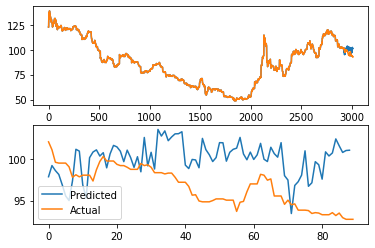

In [ ]:
plt.subplot(211)
plt.plot(df_drop['Coal_price'].values , label='Predicted')
plt.plot(df_coal['Coal_price'].values , label='Actual')


plt.subplot(212)
plt.plot(df_drop['Coal_price'][-90:].values, label='Predicted')
plt.plot(df_coal['Coal_price'][-90:].values, label='Actual')
plt.legend()
plt.show()

##2.2 recursive / (t-1Coal_price)



*  t-1시점의 y데이터 추가
- recursive model






In [ ]:
df2 = pd.read_excel("/content/gdrive/My Drive/Black_coal/data/dataset/project_dataset.xlsx")
df2 = df2.sort_values('date')
df2['date']= pd.to_datetime(df2['date'])

df2 = df2.set_index('date')
df2 = df2[df2.index < '2019-01-02']
df2 = df2.reset_index()
df2 = df2[['date','Coal_price']] 
df2 = df2.rename(columns ={'date':'ds'})
shift= df2['Coal_price'].shift(1)
shift[0]=df2['Coal_price'][0]

shift2 = df2[['ds','Coal_price']]
shift2=df2.rename(columns={'Coal_price' : 'shift'})
shift2['shift']=shift
shift2



,ds,shift
0,2011-01-01,122.65
1,2011-01-02,122.65
2,2011-01-03,122.65
3,2011-01-04,136.50
4,2011-01-05,137.30
...,...,...
2918,2018-12-28,101.55
2919,2018-12-29,101.90
2920,2018-12-30,101.90
2921,2018-12-31,101.90


In [ ]:
df_merge=df_merge.reset_index()

In [ ]:
df_merge=df_merge.rename(columns={'date':'ds'})
df_merge

,ds,Coal_price,Brent_fut,iron,copper_fut,WTI_fut,WTI,LNG_fut,bdi,USD/AUD(호주),...,영국지수,독일지수,S&P500지수,항셍지수,나스닥지수,코스피지수,니케이225지수,유로스톡스50지수,호주지수,캐나다지수
0,2011-01-01,122.65,94.750000,168.300000,9644.000000,91.380000,91.400000,61.070000,1773.000000,0.984470,...,5899.899902,6914.189941,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039,4745.200195,13443.200195
1,2011-01-02,122.65,94.750000,168.300000,9644.000000,91.380000,91.400000,61.070000,1773.000000,0.984470,...,5899.899902,6914.189941,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039,4745.200195,13443.200195
2,2011-01-03,136.50,94.840000,170.000000,9644.000000,91.550000,91.560000,61.070000,1773.000000,0.979010,...,5899.899902,6989.740234,1271.869995,23436.050781,2691.520020,2070.080078,10228.919922,2839.429932,4745.200195,13443.200195
3,2011-01-04,137.30,93.530000,172.100000,9619.250000,89.380000,89.230000,58.320000,1693.000000,0.983370,...,6013.899902,6975.350098,1270.199951,23668.480469,2681.250000,2085.139893,10398.099609,2844.169922,4742.500000,13402.299805
4,2011-01-05,130.65,95.500000,174.500000,9586.000000,90.300000,90.380000,56.400000,1621.000000,0.992850,...,6043.899902,6939.819824,1276.560059,23757.820312,2702.199951,2082.550049,10380.769531,2833.739990,4714.899902,13396.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3007,2019-03-27,NaN,84.124730,72.446181,6703.428741,74.566090,74.733597,71.442419,1402.027680,1.372171,...,7298.123222,11897.295010,2918.493060,29237.210404,8123.580208,2252.528334,23546.358166,3263.093898,6171.147374,15954.943396
3008,2019-03-28,NaN,84.199753,72.354536,6691.270487,74.562116,74.750119,71.307777,1399.854283,1.373349,...,7290.969546,11893.885654,2919.238593,29209.282776,8123.496620,2252.020118,23542.239644,3261.886242,6175.229169,15943.334716
3009,2019-03-29,NaN,84.291781,72.370737,6683.270496,74.628844,74.817677,71.206234,1396.475330,1.374941,...,7287.452489,11888.538235,2919.920821,29195.805869,8122.842283,2249.926048,23541.187552,3259.948145,6176.074040,15927.833254
3010,2019-03-30,NaN,84.363165,72.375087,6673.171699,74.731828,74.938001,71.049927,1390.815421,1.376403,...,7283.986305,11884.435037,2920.547457,29173.373865,8122.769151,2247.524109,23537.235686,3257.373048,6176.594855,15915.512454


In [ ]:
df_merge = pd.merge(df_merge,shift2,on='ds',how='outer')
df_merge

,ds,Coal_price,Brent_fut,iron,copper_fut,WTI_fut,WTI,LNG_fut,bdi,USD/AUD(호주),...,독일지수,S&P500지수,항셍지수,나스닥지수,코스피지수,니케이225지수,유로스톡스50지수,호주지수,캐나다지수,shift
0,2011-01-01,122.65,94.750000,168.300000,9644.000000,91.380000,91.400000,61.070000,1773.000000,0.984470,...,6914.189941,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039,4745.200195,13443.200195,122.65
1,2011-01-02,122.65,94.750000,168.300000,9644.000000,91.380000,91.400000,61.070000,1773.000000,0.984470,...,6914.189941,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039,4745.200195,13443.200195,122.65
2,2011-01-03,136.50,94.840000,170.000000,9644.000000,91.550000,91.560000,61.070000,1773.000000,0.979010,...,6989.740234,1271.869995,23436.050781,2691.520020,2070.080078,10228.919922,2839.429932,4745.200195,13443.200195,122.65
3,2011-01-04,137.30,93.530000,172.100000,9619.250000,89.380000,89.230000,58.320000,1693.000000,0.983370,...,6975.350098,1270.199951,23668.480469,2681.250000,2085.139893,10398.099609,2844.169922,4742.500000,13402.299805,136.50
4,2011-01-05,130.65,95.500000,174.500000,9586.000000,90.300000,90.380000,56.400000,1621.000000,0.992850,...,6939.819824,1276.560059,23757.820312,2702.199951,2082.550049,10380.769531,2833.739990,4714.899902,13396.000000,137.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3007,2019-03-27,NaN,84.124730,72.446181,6703.428741,74.566090,74.733597,71.442419,1402.027680,1.372171,...,11897.295010,2918.493060,29237.210404,8123.580208,2252.528334,23546.358166,3263.093898,6171.147374,15954.943396,NaN
3008,2019-03-28,NaN,84.199753,72.354536,6691.270487,74.562116,74.750119,71.307777,1399.854283,1.373349,...,11893.885654,2919.238593,29209.282776,8123.496620,2252.020118,23542.239644,3261.886242,6175.229169,15943.334716,NaN
3009,2019-03-29,NaN,84.291781,72.370737,6683.270496,74.628844,74.817677,71.206234,1396.475330,1.374941,...,11888.538235,2919.920821,29195.805869,8122.842283,2249.926048,23541.187552,3259.948145,6176.074040,15927.833254,NaN
3010,2019-03-30,NaN,84.363165,72.375087,6673.171699,74.731828,74.938001,71.049927,1390.815421,1.376403,...,11884.435037,2920.547457,29173.373865,8122.769151,2247.524109,23537.235686,3257.373048,6176.594855,15915.512454,NaN


In [ ]:
df_drop = df_merge.drop('ds',axis=1)

In [ ]:
df_merge=df_merge.set_index('ds')

In [ ]:
for i in range (89):
    
  
  # 학습과 테스트 데이터 분리
  split =  len(df_merge[:"2017-12-31"])
  split1 =  len(df_merge[:"2018-12-31"])
  
  df_train = df_drop[:split+i]
  df_test = df_drop[split+i:split1+i]
  df_predict = df_drop[len(df_merge[:"2018-12-31"]):len(df_merge[:"2019-01-01"])]

  df_train_y = df_train.loc[:,'Coal_price']
  df_train_x = df_train.drop('Coal_price', axis=1)
  df_test_y = df_test.loc[:,'Coal_price']
  df_test_x = df_test.drop('Coal_price', axis=1)
  # 나중에 예측값과 비교하기 위해 test 데이터 복제본 저장
  df_test_orig = df_coal.loc[:, 'Coal_price']
  df_predict_x = df_predict.drop('Coal_price', axis=1)
  df_predict_x = df_predict_x[:]



  XG_model_month = xgb.XGBRegressor(learning_rate=0.1,max_depth=6,n_estimators=200)
  XG_model_month.fit(df_train_x, df_train_y, eval_set=[(df_test_x, df_test_y)], early_stopping_rounds=100,verbose=False)
  
  xgboost = XG_model_month.predict(df_predict_x)

  # 실제 값과 예측 값을 하나의 DataFrame으로 만들고 visualize
  result=pd.concat([df_test_orig.reset_index(), pd.DataFrame(xgboost, columns=['xgboost'])], axis=1, ignore_index=False)
  
  df_drop['Coal_price'][len(df_merge[:"2018-12-31"])+i]=result['xgboost'][0]
  df_drop['shift'][len(df_merge[:"2019-01-01"])+i]=result['xgboost'][0]
  print(df_drop['Coal_price'][len(df_merge[:"2018-12-31"])]+i)
  print(df_drop['shift'][len(df_merge[:"2019-01-01"])]+i)

[05:57:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
102.97969818115234
102.97969818115234
[05:57:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
103.97969818115234
103.97969818115234
[05:57:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
104.97969818115234
104.97969818115234
[05:57:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
105.97969818115234
105.97969818115234
[05:57:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
106.97969818115234
106.97969818115234
[05:57:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
107.97969818115234
107.97969818115234
[05:57:38]

###result

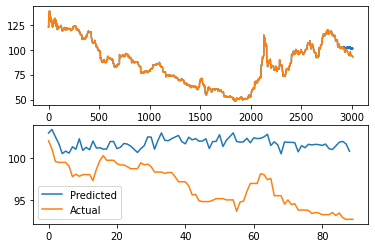

In [ ]:
plt.subplot(211)
plt.plot(df_drop['Coal_price'].values , label='Predicted')
plt.plot(df_coal['Coal_price'].values , label='Actual')


plt.subplot(212)
plt.plot(df_drop['Coal_price'][-90:].values, label='Predicted')
plt.plot(df_coal['Coal_price'][-90:].values, label='Actual')
plt.legend()
plt.show()

##2.3 recursive(3month val)

*   30개 변수 prophe prediction 값 
*   y_pred값을 validation셋에 추가


Data

*   df는 실제값으로 2018년도 12월 31일까지
*   df_pred는 prophet으로 prediction한 값 2019년부터 1월 1일까지 (Coal_price 제외)
*   df_merge에 예측에 필요한 coal_price값 제외하고 merge






In [ ]:
df = pd.read_excel("/content/gdrive/My Drive/Black_coal/data/dataset/project_dataset.xlsx")
df = df.sort_values('date')
df['date']= pd.to_datetime(df['date'])

df = df.set_index('date')
df = df[df.index < '2019-01-01']
df = df.reset_index()
df  

,date,Coal_price,iron,Brent_fut,copper_fut,WTI_fut,WTI,LNG_fut,bdi,USD/AUD(호주),...,영국지수,독일지수,S&P500지수,항셍지수,나스닥지수,코스피지수,니케이225지수,유로스톡스50지수,호주지수,캐나다지수
0,2011-01-01,122.65,168.3,94.75,9644.00,91.38,91.40,61.07,1773.0,0.98447,...,5899.899902,6914.189941,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039,4745.200195,13443.200195
1,2011-01-02,122.65,168.3,94.75,9644.00,91.38,91.40,61.07,1773.0,0.98447,...,5899.899902,6914.189941,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039,4745.200195,13443.200195
2,2011-01-03,136.50,170.0,94.84,9644.00,91.55,91.56,61.07,1773.0,0.97901,...,5899.899902,6989.740234,1271.869995,23436.050781,2691.520020,2070.080078,10228.919922,2839.429932,4745.200195,13443.200195
3,2011-01-04,137.30,172.1,93.53,9619.25,89.38,89.23,58.32,1693.0,0.98337,...,6013.899902,6975.350098,1270.199951,23668.480469,2681.250000,2085.139893,10398.099609,2844.169922,4742.500000,13402.299805
4,2011-01-05,130.65,174.5,95.50,9586.00,90.30,90.38,56.40,1621.0,0.99285,...,6043.899902,6939.819824,1276.560059,23757.820312,2702.199951,2082.550049,10380.769531,2833.739990,4714.899902,13396.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2917,2018-12-27,101.55,69.0,52.16,5972.00,44.61,45.23,64.36,1271.0,1.41347,...,6584.700195,10381.509766,2488.830078,25478.880859,6579.490234,2028.439941,20077.619141,2937.360107,5597.200195,14165.200195
2918,2018-12-28,101.90,69.2,52.20,5992.25,45.33,44.92,62.63,1271.0,1.42140,...,6734.000000,10558.959961,2485.739990,25504.199219,6584.520020,2041.040039,20014.769531,2986.530029,5654.299805,14222.000000
2919,2018-12-29,101.90,69.2,52.20,5992.25,45.33,44.92,62.63,1271.0,1.42140,...,6734.000000,10558.959961,2485.739990,25504.199219,6584.520020,2041.040039,20014.769531,2986.530029,5654.299805,14222.000000
2920,2018-12-30,101.90,69.2,52.20,5992.25,45.33,45.34,62.63,1271.0,1.42140,...,6734.000000,10558.959961,2485.739990,25504.199219,6584.520020,2041.040039,20014.769531,2986.530029,5654.299805,14222.000000


In [ ]:
df_pred = pd.read_csv("/content/gdrive/My Drive/Black_coal/data/dataset/prophet_pred/prophet_pred_final.csv", encoding = 'utf-8-sig')
df_pred = df_pred.rename(columns ={'ds':'date'})
df_pred['date']= pd.to_datetime(df_pred['date'])

df_pred = df_pred.set_index('date')
df_pred = df_pred.reset_index()
df_pred

,date,Brent_fut,iron,copper_fut,WTI_fut,WTI,LNG_fut,bdi,USD/AUD(호주),USD/CAD(캐나다),...,영국지수,독일지수,S&P500지수,항셍지수,나스닥지수,코스피지수,니케이225지수,유로스톡스50지수,호주지수,캐나다지수
0,2019-01-01,75.812228,71.545954,6619.631419,66.938042,66.994911,70.338440,1544.769285,1.381137,1.304337,...,7288.361045,11940.424072,2850.111402,28692.519075,7811.282865,2235.177588,23500.663279,3266.153594,6065.461711,15684.428936
1,2019-01-02,76.057960,71.975804,6620.989242,67.089308,67.144982,70.440536,1537.793650,1.379890,1.303019,...,7298.230085,11961.280178,2858.950798,28764.780039,7844.147829,2238.647614,23578.059165,3268.671637,6078.348331,15717.862805
2,2019-01-03,76.142337,72.191391,6626.679451,67.154771,67.230336,70.546706,1527.818872,1.379584,1.301855,...,7304.254455,11973.726891,2866.271727,28815.469475,7869.908366,2241.715687,23638.259125,3269.909214,6089.633134,15746.566127
3,2019-01-04,76.257750,72.401154,6634.778046,67.287031,67.354341,70.672519,1516.018237,1.379166,1.300963,...,7312.470514,11978.516388,2871.711769,28879.213400,7889.392367,2243.873936,23690.803718,3269.718077,6094.977334,15766.852091
4,2019-01-05,76.299317,72.574080,6635.657939,67.374272,67.447421,70.721252,1501.790617,1.378242,1.300217,...,7316.875265,11977.567232,2875.054906,28918.499131,7903.145770,2246.051368,23722.119596,3267.760779,6096.839291,15780.126382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,2019-03-27,84.124730,72.446181,6703.428741,74.566090,74.733597,71.442419,1402.027680,1.372171,1.323902,...,7298.123222,11897.295010,2918.493060,29237.210404,8123.580208,2252.528334,23546.358166,3263.093898,6171.147374,15954.943396
86,2019-03-28,84.199753,72.354536,6691.270487,74.562116,74.750119,71.307777,1399.854283,1.373349,1.323854,...,7290.969546,11893.885654,2919.238593,29209.282776,8123.496620,2252.020118,23542.239644,3261.886242,6175.229169,15943.334716
87,2019-03-29,84.291781,72.370737,6683.270496,74.628844,74.817677,71.206234,1396.475330,1.374941,1.323919,...,7287.452489,11888.538235,2919.920821,29195.805869,8122.842283,2249.926048,23541.187552,3259.948145,6176.074040,15927.833254
88,2019-03-30,84.363165,72.375087,6673.171699,74.731828,74.938001,71.049927,1390.815421,1.376403,1.323784,...,7283.986305,11884.435037,2920.547457,29173.373865,8122.769151,2247.524109,23537.235686,3257.373048,6176.594855,15915.512454


In [ ]:
df_merge = pd.merge(df, df_pred, on=['date', 'Brent_fut', 'iron', 'copper_fut', 'WTI_fut', 'WTI', 'LNG_fut',
       'bdi', 'USD/AUD(호주)', 'USD/CAD(캐나다)', 'USD/COP(콜롬비아)', 'US 달러지수',
       'USD/IDR(인도네시아)', 'USD/RUB(러시아)', 'USD/ZAR(자메이카)', '상하이종합지수', '인도지수',
       '브라질지수', '다우존스지수', '프랑스지수', '영국지수', '독일지수', 'S&P500지수', '항셍지수', '나스닥지수',
       '코스피지수', '니케이225지수', '유로스톡스50지수', '호주지수', '캐나다지수'], how='outer')
       
df_merge = df_merge[['date', 'Coal_price', 'Brent_fut', 'iron', 'copper_fut', 'WTI_fut', 'WTI', 'LNG_fut',
       'bdi', 'USD/AUD(호주)', 'USD/CAD(캐나다)', 'USD/COP(콜롬비아)', 'US 달러지수',
       'USD/IDR(인도네시아)', 'USD/RUB(러시아)', 'USD/ZAR(자메이카)', '상하이종합지수', '인도지수',
       '브라질지수', '다우존스지수', '프랑스지수', '영국지수', '독일지수', 'S&P500지수', '항셍지수', '나스닥지수',
       '코스피지수', '니케이225지수', '유로스톡스50지수', '호주지수', '캐나다지수']]
df_merge['date']= pd.to_datetime(df_merge['date'])

df_merge

,date,Coal_price,Brent_fut,iron,copper_fut,WTI_fut,WTI,LNG_fut,bdi,USD/AUD(호주),...,영국지수,독일지수,S&P500지수,항셍지수,나스닥지수,코스피지수,니케이225지수,유로스톡스50지수,호주지수,캐나다지수
0,2011-01-01,122.65,94.750000,168.300000,9644.000000,91.380000,91.400000,61.070000,1773.000000,0.984470,...,5899.899902,6914.189941,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039,4745.200195,13443.200195
1,2011-01-02,122.65,94.750000,168.300000,9644.000000,91.380000,91.400000,61.070000,1773.000000,0.984470,...,5899.899902,6914.189941,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039,4745.200195,13443.200195
2,2011-01-03,136.50,94.840000,170.000000,9644.000000,91.550000,91.560000,61.070000,1773.000000,0.979010,...,5899.899902,6989.740234,1271.869995,23436.050781,2691.520020,2070.080078,10228.919922,2839.429932,4745.200195,13443.200195
3,2011-01-04,137.30,93.530000,172.100000,9619.250000,89.380000,89.230000,58.320000,1693.000000,0.983370,...,6013.899902,6975.350098,1270.199951,23668.480469,2681.250000,2085.139893,10398.099609,2844.169922,4742.500000,13402.299805
4,2011-01-05,130.65,95.500000,174.500000,9586.000000,90.300000,90.380000,56.400000,1621.000000,0.992850,...,6043.899902,6939.819824,1276.560059,23757.820312,2702.199951,2082.550049,10380.769531,2833.739990,4714.899902,13396.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3007,2019-03-27,NaN,84.124730,72.446181,6703.428741,74.566090,74.733597,71.442419,1402.027680,1.372171,...,7298.123222,11897.295010,2918.493060,29237.210404,8123.580208,2252.528334,23546.358166,3263.093898,6171.147374,15954.943396
3008,2019-03-28,NaN,84.199753,72.354536,6691.270487,74.562116,74.750119,71.307777,1399.854283,1.373349,...,7290.969546,11893.885654,2919.238593,29209.282776,8123.496620,2252.020118,23542.239644,3261.886242,6175.229169,15943.334716
3009,2019-03-29,NaN,84.291781,72.370737,6683.270496,74.628844,74.817677,71.206234,1396.475330,1.374941,...,7287.452489,11888.538235,2919.920821,29195.805869,8122.842283,2249.926048,23541.187552,3259.948145,6176.074040,15927.833254
3010,2019-03-30,NaN,84.363165,72.375087,6673.171699,74.731828,74.938001,71.049927,1390.815421,1.376403,...,7283.986305,11884.435037,2920.547457,29173.373865,8122.769151,2247.524109,23537.235686,3257.373048,6176.594855,15915.512454


In [ ]:
df_drop = df_merge.drop('date',axis=1)
df_drop

,Coal_price,Brent_fut,iron,copper_fut,WTI_fut,WTI,LNG_fut,bdi,USD/AUD(호주),USD/CAD(캐나다),...,영국지수,독일지수,S&P500지수,항셍지수,나스닥지수,코스피지수,니케이225지수,유로스톡스50지수,호주지수,캐나다지수
0,122.65,94.750000,168.300000,9644.000000,91.380000,91.400000,61.070000,1773.000000,0.984470,0.999600,...,5899.899902,6914.189941,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039,4745.200195,13443.200195
1,122.65,94.750000,168.300000,9644.000000,91.380000,91.400000,61.070000,1773.000000,0.984470,0.999600,...,5899.899902,6914.189941,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039,4745.200195,13443.200195
2,136.50,94.840000,170.000000,9644.000000,91.550000,91.560000,61.070000,1773.000000,0.979010,0.992700,...,5899.899902,6989.740234,1271.869995,23436.050781,2691.520020,2070.080078,10228.919922,2839.429932,4745.200195,13443.200195
3,137.30,93.530000,172.100000,9619.250000,89.380000,89.230000,58.320000,1693.000000,0.983370,0.992390,...,6013.899902,6975.350098,1270.199951,23668.480469,2681.250000,2085.139893,10398.099609,2844.169922,4742.500000,13402.299805
4,130.65,95.500000,174.500000,9586.000000,90.300000,90.380000,56.400000,1621.000000,0.992850,0.997000,...,6043.899902,6939.819824,1276.560059,23757.820312,2702.199951,2082.550049,10380.769531,2833.739990,4714.899902,13396.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3007,NaN,84.124730,72.446181,6703.428741,74.566090,74.733597,71.442419,1402.027680,1.372171,1.323902,...,7298.123222,11897.295010,2918.493060,29237.210404,8123.580208,2252.528334,23546.358166,3263.093898,6171.147374,15954.943396
3008,NaN,84.199753,72.354536,6691.270487,74.562116,74.750119,71.307777,1399.854283,1.373349,1.323854,...,7290.969546,11893.885654,2919.238593,29209.282776,8123.496620,2252.020118,23542.239644,3261.886242,6175.229169,15943.334716
3009,NaN,84.291781,72.370737,6683.270496,74.628844,74.817677,71.206234,1396.475330,1.374941,1.323919,...,7287.452489,11888.538235,2919.920821,29195.805869,8122.842283,2249.926048,23541.187552,3259.948145,6176.074040,15927.833254
3010,NaN,84.363165,72.375087,6673.171699,74.731828,74.938001,71.049927,1390.815421,1.376403,1.323784,...,7283.986305,11884.435037,2920.547457,29173.373865,8122.769151,2247.524109,23537.235686,3257.373048,6176.594855,15915.512454


In [ ]:
df_coal = pd.read_csv("/content/gdrive/My Drive/Black_coal/data/dataset/project_dataset.csv", encoding = 'utf-8-sig')
df_coal = df_coal.sort_values('date')
df_coal['date']= pd.to_datetime(df_coal['date'])

df_coal = df_coal.set_index('date')
df_coal = df_coal[df_coal.index < '2019-04-01']

df_coal = df_coal.reset_index()
df_coal = df_coal[['date','Coal_price']]
df_coal

,date,Coal_price
0,2011-01-01,122.65
1,2011-01-02,122.65
2,2011-01-03,136.50
3,2011-01-04,137.30
4,2011-01-05,130.65
...,...,...
3007,2019-03-27,93.50
3008,2019-03-28,92.95
3009,2019-03-29,92.75
3010,2019-03-30,92.75


In [ ]:
df_merge = df_merge.set_index('date')

In [ ]:
for i in range (89):
    
  
  # 학습과 테스트 데이터 분리
  split =  len(df_merge[:"2018-09-30"])
  split1 =  len(df_merge[:"2018-12-31"])
  
  df_train = df_drop[:split+i]
  df_test = df_drop[split+i:split1+i]
  df_predict = df_drop[len(df_merge[:"2018-12-31"]):len(df_merge[:"2019-01-01"])]

  df_train_y = df_train.loc[:,'Coal_price']
  df_train_x = df_train.drop('Coal_price', axis=1)
  df_test_y = df_test.loc[:,'Coal_price']
  df_test_x = df_test.drop('Coal_price', axis=1)
  # 나중에 예측값과 비교하기 위해 test 데이터 복제본 저장
  df_test_orig = df_coal.loc[:, 'Coal_price']
  df_predict_x = df_predict.drop('Coal_price', axis=1)
  df_predict_x = df_predict_x[:]



  XG_model_month = xgb.XGBRegressor(learning_rate=0.1,max_depth=6,n_estimators=200)
  XG_model_month.fit(df_train_x, df_train_y, eval_set=[(df_test_x, df_test_y)], early_stopping_rounds=100,verbose=False)
  
  xgboost = XG_model_month.predict(df_predict_x)

  # 실제 값과 예측 값을 하나의 DataFrame으로 만들고 visualize
  result=pd.concat([df_test_orig.reset_index(), pd.DataFrame(xgboost, columns=['xgboost'])], axis=1, ignore_index=False)
  
  df_drop['Coal_price'][len(df_merge[:"2018-12-31"])+i]=result['xgboost'][0]
  # df_drop['shift'][len(df_merge[:"2019-01-01"])+i]=result['xgboost'][0]
  print(df_drop['Coal_price'][len(df_merge[:"2018-12-31"])]+i)
  # print(df_drop['shift'][len(df_merge[:"2019-01-01"])]+i)

[06:00:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
112.48212432861328
[06:00:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
113.48212432861328
[06:00:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
114.48212432861328
[06:00:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
115.48212432861328
[06:00:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
116.48212432861328
[06:00:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
117.48212432861328
[06:00:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederro

###result

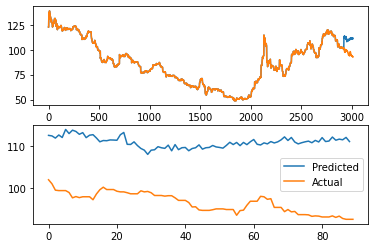

In [ ]:
plt.subplot(211)
plt.plot(df_drop['Coal_price'].values , label='Predicted')
plt.plot(df_coal['Coal_price'].values , label='Actual')


plt.subplot(212)
plt.plot(df_drop['Coal_price'][-90:].values, label='Predicted')
plt.plot(df_coal['Coal_price'][-90:].values, label='Actual')
plt.legend()
plt.show()

## 2.4 recursive/(t-1/3month val)



*  t-1시점의 y데이터 추가
- recursive model






In [ ]:
df2 = pd.read_excel("/content/gdrive/My Drive/Black_coal/data/dataset/project_dataset.xlsx")
df2 = df2.sort_values('date')
df2['date']= pd.to_datetime(df2['date'])

df2 = df2.set_index('date')
df2 = df2[df2.index < '2019-01-02']
df2 = df2.reset_index()
df2 = df2[['date','Coal_price']] 
df2 = df2.rename(columns ={'date':'ds'})
shift= df2['Coal_price'].shift(1)
shift[0]=df2['Coal_price'][0]

shift2 = df2[['ds','Coal_price']]
shift2=df2.rename(columns={'Coal_price' : 'shift'})
shift2['shift']=shift
shift2



,ds,shift
0,2011-01-01,122.65
1,2011-01-02,122.65
2,2011-01-03,122.65
3,2011-01-04,136.50
4,2011-01-05,137.30
...,...,...
2918,2018-12-28,101.55
2919,2018-12-29,101.90
2920,2018-12-30,101.90
2921,2018-12-31,101.90


In [ ]:
df_merge=df_merge.reset_index()

In [ ]:
df_merge=df_merge.rename(columns={'date':'ds'})
df_merge

,ds,Coal_price,Brent_fut,iron,copper_fut,WTI_fut,WTI,LNG_fut,bdi,USD/AUD(호주),...,영국지수,독일지수,S&P500지수,항셍지수,나스닥지수,코스피지수,니케이225지수,유로스톡스50지수,호주지수,캐나다지수
0,2011-01-01,122.65,94.750000,168.300000,9644.000000,91.380000,91.400000,61.070000,1773.000000,0.984470,...,5899.899902,6914.189941,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039,4745.200195,13443.200195
1,2011-01-02,122.65,94.750000,168.300000,9644.000000,91.380000,91.400000,61.070000,1773.000000,0.984470,...,5899.899902,6914.189941,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039,4745.200195,13443.200195
2,2011-01-03,136.50,94.840000,170.000000,9644.000000,91.550000,91.560000,61.070000,1773.000000,0.979010,...,5899.899902,6989.740234,1271.869995,23436.050781,2691.520020,2070.080078,10228.919922,2839.429932,4745.200195,13443.200195
3,2011-01-04,137.30,93.530000,172.100000,9619.250000,89.380000,89.230000,58.320000,1693.000000,0.983370,...,6013.899902,6975.350098,1270.199951,23668.480469,2681.250000,2085.139893,10398.099609,2844.169922,4742.500000,13402.299805
4,2011-01-05,130.65,95.500000,174.500000,9586.000000,90.300000,90.380000,56.400000,1621.000000,0.992850,...,6043.899902,6939.819824,1276.560059,23757.820312,2702.199951,2082.550049,10380.769531,2833.739990,4714.899902,13396.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3007,2019-03-27,NaN,84.124730,72.446181,6703.428741,74.566090,74.733597,71.442419,1402.027680,1.372171,...,7298.123222,11897.295010,2918.493060,29237.210404,8123.580208,2252.528334,23546.358166,3263.093898,6171.147374,15954.943396
3008,2019-03-28,NaN,84.199753,72.354536,6691.270487,74.562116,74.750119,71.307777,1399.854283,1.373349,...,7290.969546,11893.885654,2919.238593,29209.282776,8123.496620,2252.020118,23542.239644,3261.886242,6175.229169,15943.334716
3009,2019-03-29,NaN,84.291781,72.370737,6683.270496,74.628844,74.817677,71.206234,1396.475330,1.374941,...,7287.452489,11888.538235,2919.920821,29195.805869,8122.842283,2249.926048,23541.187552,3259.948145,6176.074040,15927.833254
3010,2019-03-30,NaN,84.363165,72.375087,6673.171699,74.731828,74.938001,71.049927,1390.815421,1.376403,...,7283.986305,11884.435037,2920.547457,29173.373865,8122.769151,2247.524109,23537.235686,3257.373048,6176.594855,15915.512454


In [ ]:
df_merge = pd.merge(df_merge,shift2,on='ds',how='outer')
df_merge

,ds,Coal_price,Brent_fut,iron,copper_fut,WTI_fut,WTI,LNG_fut,bdi,USD/AUD(호주),...,독일지수,S&P500지수,항셍지수,나스닥지수,코스피지수,니케이225지수,유로스톡스50지수,호주지수,캐나다지수,shift
0,2011-01-01,122.65,94.750000,168.300000,9644.000000,91.380000,91.400000,61.070000,1773.000000,0.984470,...,6914.189941,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039,4745.200195,13443.200195,122.65
1,2011-01-02,122.65,94.750000,168.300000,9644.000000,91.380000,91.400000,61.070000,1773.000000,0.984470,...,6914.189941,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039,4745.200195,13443.200195,122.65
2,2011-01-03,136.50,94.840000,170.000000,9644.000000,91.550000,91.560000,61.070000,1773.000000,0.979010,...,6989.740234,1271.869995,23436.050781,2691.520020,2070.080078,10228.919922,2839.429932,4745.200195,13443.200195,122.65
3,2011-01-04,137.30,93.530000,172.100000,9619.250000,89.380000,89.230000,58.320000,1693.000000,0.983370,...,6975.350098,1270.199951,23668.480469,2681.250000,2085.139893,10398.099609,2844.169922,4742.500000,13402.299805,136.50
4,2011-01-05,130.65,95.500000,174.500000,9586.000000,90.300000,90.380000,56.400000,1621.000000,0.992850,...,6939.819824,1276.560059,23757.820312,2702.199951,2082.550049,10380.769531,2833.739990,4714.899902,13396.000000,137.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3007,2019-03-27,NaN,84.124730,72.446181,6703.428741,74.566090,74.733597,71.442419,1402.027680,1.372171,...,11897.295010,2918.493060,29237.210404,8123.580208,2252.528334,23546.358166,3263.093898,6171.147374,15954.943396,NaN
3008,2019-03-28,NaN,84.199753,72.354536,6691.270487,74.562116,74.750119,71.307777,1399.854283,1.373349,...,11893.885654,2919.238593,29209.282776,8123.496620,2252.020118,23542.239644,3261.886242,6175.229169,15943.334716,NaN
3009,2019-03-29,NaN,84.291781,72.370737,6683.270496,74.628844,74.817677,71.206234,1396.475330,1.374941,...,11888.538235,2919.920821,29195.805869,8122.842283,2249.926048,23541.187552,3259.948145,6176.074040,15927.833254,NaN
3010,2019-03-30,NaN,84.363165,72.375087,6673.171699,74.731828,74.938001,71.049927,1390.815421,1.376403,...,11884.435037,2920.547457,29173.373865,8122.769151,2247.524109,23537.235686,3257.373048,6176.594855,15915.512454,NaN


In [ ]:
df_drop = df_merge.drop('ds',axis=1)

In [ ]:
df_merge=df_merge.set_index('ds')

In [ ]:
for i in range (89):
    
  
  # 학습과 테스트 데이터 분리
  split =  len(df_merge[:"2018-09-30"])
  split1 =  len(df_merge[:"2018-12-31"])
  
  df_train = df_drop[:split+i]
  df_test = df_drop[split+i:split1+i]
  df_predict = df_drop[len(df_merge[:"2018-12-31"]):len(df_merge[:"2019-01-01"])]

  df_train_y = df_train.loc[:,'Coal_price']
  df_train_x = df_train.drop('Coal_price', axis=1)
  df_test_y = df_test.loc[:,'Coal_price']
  df_test_x = df_test.drop('Coal_price', axis=1)
  # 나중에 예측값과 비교하기 위해 test 데이터 복제본 저장
  df_test_orig = df_coal.loc[:, 'Coal_price']
  df_predict_x = df_predict.drop('Coal_price', axis=1)
  df_predict_x = df_predict_x[:]



  XG_model_month = xgb.XGBRegressor(learning_rate=0.1,max_depth=6,n_estimators=200)
  XG_model_month.fit(df_train_x, df_train_y, eval_set=[(df_test_x, df_test_y)], early_stopping_rounds=100,verbose=False)
  
  xgboost = XG_model_month.predict(df_predict_x)

  # 실제 값과 예측 값을 하나의 DataFrame으로 만들고 visualize
  result=pd.concat([df_test_orig.reset_index(), pd.DataFrame(xgboost, columns=['xgboost'])], axis=1, ignore_index=False)
  
  df_drop['Coal_price'][len(df_merge[:"2018-12-31"])+i]=result['xgboost'][0]
  df_drop['shift'][len(df_merge[:"2019-01-01"])+i]=result['xgboost'][0]
  print(df_drop['Coal_price'][len(df_merge[:"2018-12-31"])]+i)
  print(df_drop['shift'][len(df_merge[:"2019-01-01"])]+i)

[06:03:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
101.75768280029297
101.75768280029297
[06:03:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
102.75768280029297
102.75768280029297
[06:03:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
103.75768280029297
103.75768280029297
[06:03:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
104.75768280029297
104.75768280029297
[06:03:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
105.75768280029297
105.75768280029297
[06:03:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
106.75768280029297
106.75768280029297
[06:03:20]

###result

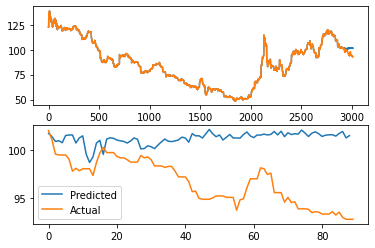

In [ ]:
plt.subplot(211)
plt.plot(df_drop['Coal_price'].values , label='Predicted')
plt.plot(df_coal['Coal_price'].values , label='Actual')


plt.subplot(212)
plt.plot(df_drop['Coal_price'][-90:].values, label='Predicted')
plt.plot(df_coal['Coal_price'][-90:].values, label='Actual')
plt.legend()
plt.show()

##2.5 recursive - day val

*   30개 변수 prophe prediction 값 
*   y_pred값을 validation셋에 추가


Data

*   df는 실제값으로 2018년도 12월 31일까지
*   df_pred는 prophet으로 prediction한 값 2019년부터 1월 1일까지 (Coal_price 제외)
*   df_merge에 예측에 필요한 coal_price값 제외하고 merge






In [ ]:
df = pd.read_excel("/content/gdrive/My Drive/Black_coal/data/dataset/project_dataset.xlsx")
df = df.sort_values('date')
df['date']= pd.to_datetime(df['date'])

df = df.set_index('date')
df = df[df.index < '2019-01-01']
df = df.reset_index()

In [ ]:
df_pred = pd.read_csv("/content/gdrive/My Drive/Black_coal/data/dataset/prophet_pred/prophet_pred_final.csv", encoding = 'utf-8-sig')
df_pred = df_pred.rename(columns ={'ds':'date'})
df_pred['date']= pd.to_datetime(df_pred['date'])

df_pred = df_pred.set_index('date')
df_pred = df_pred.reset_index()


In [ ]:
df_merge = pd.merge(df, df_pred, on=['date', 'Brent_fut', 'iron', 'copper_fut', 'WTI_fut', 'WTI', 'LNG_fut',
       'bdi', 'USD/AUD(호주)', 'USD/CAD(캐나다)', 'USD/COP(콜롬비아)', 'US 달러지수',
       'USD/IDR(인도네시아)', 'USD/RUB(러시아)', 'USD/ZAR(자메이카)', '상하이종합지수', '인도지수',
       '브라질지수', '다우존스지수', '프랑스지수', '영국지수', '독일지수', 'S&P500지수', '항셍지수', '나스닥지수',
       '코스피지수', '니케이225지수', '유로스톡스50지수', '호주지수', '캐나다지수'], how='outer')
       
df_merge = df_merge[['date', 'Coal_price', 'Brent_fut', 'iron', 'copper_fut', 'WTI_fut', 'WTI', 'LNG_fut',
       'bdi', 'USD/AUD(호주)', 'USD/CAD(캐나다)', 'USD/COP(콜롬비아)', 'US 달러지수',
       'USD/IDR(인도네시아)', 'USD/RUB(러시아)', 'USD/ZAR(자메이카)', '상하이종합지수', '인도지수',
       '브라질지수', '다우존스지수', '프랑스지수', '영국지수', '독일지수', 'S&P500지수', '항셍지수', '나스닥지수',
       '코스피지수', '니케이225지수', '유로스톡스50지수', '호주지수', '캐나다지수']]
df_merge['date']= pd.to_datetime(df_merge['date'])



In [ ]:
df_drop = df_merge.drop('date',axis=1)

In [ ]:
df_coal = pd.read_csv("/content/gdrive/My Drive/Black_coal/data/dataset/project_dataset.csv", encoding = 'utf-8-sig')
df_coal = df_coal.sort_values('date')
df_coal['date']= pd.to_datetime(df_coal['date'])

df_coal = df_coal.set_index('date')
df_coal = df_coal[df_coal.index < '2019-04-01']

df_coal = df_coal.reset_index()
df_coal = df_coal[['date','Coal_price']]


In [ ]:
df_merge = df_merge.set_index('date')

In [ ]:
for i in range (89):
    
  
  # 학습과 테스트 데이터 분리
  split =  len(df_merge[:"2018-12-30"])
  split1 =  len(df_merge[:"2018-12-31"])
  
  df_train = df_drop[:split+i]
  df_test = df_drop[split+i:split1+i]
  df_predict = df_drop[len(df_merge[:"2018-12-31"]):len(df_merge[:"2019-01-01"])]

  df_train_y = df_train.loc[:,'Coal_price']
  df_train_x = df_train.drop('Coal_price', axis=1)
  df_test_y = df_test.loc[:,'Coal_price']
  df_test_x = df_test.drop('Coal_price', axis=1)
  # 나중에 예측값과 비교하기 위해 test 데이터 복제본 저장
  df_test_orig = df_coal.loc[:, 'Coal_price']
  df_predict_x = df_predict.drop('Coal_price', axis=1)
  df_predict_x = df_predict_x[:]



  XG_model_month = xgb.XGBRegressor(learning_rate=0.1,max_depth=6,n_estimators=200)
  XG_model_month.fit(df_train_x, df_train_y, eval_set=[(df_test_x, df_test_y)], early_stopping_rounds=100,verbose=False)
  
  xgboost = XG_model_month.predict(df_predict_x)

  # 실제 값과 예측 값을 하나의 DataFrame으로 만들고 visualize
  result=pd.concat([df_test_orig.reset_index(), pd.DataFrame(xgboost, columns=['xgboost'])], axis=1, ignore_index=False)
  
  df_drop['Coal_price'][len(df_merge[:"2018-12-31"])+i]=result['xgboost'][0]
  # df_drop['shift'][len(df_merge[:"2019-01-01"])+i]=result['xgboost'][0]
  print(df_drop['Coal_price'][len(df_merge[:"2018-12-31"])]+i)
  # print(df_drop['shift'][len(df_merge[:"2019-01-01"])]+i)

[06:06:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
111.50236511230469
[06:06:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
112.50236511230469
[06:06:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
113.50236511230469
[06:06:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
114.50236511230469
[06:06:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
115.50236511230469
[06:06:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
116.50236511230469
[06:06:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederro

###result

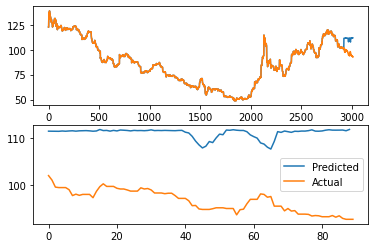

In [ ]:
plt.subplot(211)
plt.plot(df_drop['Coal_price'].values , label='Predicted')
plt.plot(df_coal['Coal_price'].values , label='Actual')


plt.subplot(212)
plt.plot(df_drop['Coal_price'][-90:].values, label='Predicted')
plt.plot(df_coal['Coal_price'][-90:].values, label='Actual')
plt.legend()
plt.show()

## 2.6 recursive - day val / t-1



*  t-1시점의 y데이터 추가
- recursive model






In [ ]:
df2 = pd.read_excel("/content/gdrive/My Drive/Black_coal/data/dataset/project_dataset.xlsx")
df2 = df2.sort_values('date')
df2['date']= pd.to_datetime(df2['date'])

df2 = df2.set_index('date')
df2 = df2[df2.index < '2019-01-02']
df2 = df2.reset_index()
df2 = df2[['date','Coal_price']] 
df2 = df2.rename(columns ={'date':'ds'})
shift= df2['Coal_price'].shift(1)
shift[0]=df2['Coal_price'][0]

shift2 = df2[['ds','Coal_price']]
shift2=df2.rename(columns={'Coal_price' : 'shift'})
shift2['shift']=shift


df_merge=df_merge.reset_index()
df_merge=df_merge.rename(columns={'date':'ds'})
df_merge = pd.merge(df_merge,shift2,on='ds',how='outer')
df_drop = df_merge.drop('ds',axis=1)

In [ ]:
df_merge=df_merge.set_index('ds')

In [ ]:
for i in range (89):
    
  
  # 학습과 테스트 데이터 분리
  split =  len(df_merge[:"2018-12-30"])
  split1 =  len(df_merge[:"2018-12-31"])
  
  df_train = df_drop[:split+i]
  df_test = df_drop[split+i:split1+i]
  df_predict = df_drop[len(df_merge[:"2018-12-31"]):len(df_merge[:"2019-01-01"])]

  df_train_y = df_train.loc[:,'Coal_price']
  df_train_x = df_train.drop('Coal_price', axis=1)
  df_test_y = df_test.loc[:,'Coal_price']
  df_test_x = df_test.drop('Coal_price', axis=1)
  # 나중에 예측값과 비교하기 위해 test 데이터 복제본 저장
  df_test_orig = df_coal.loc[:, 'Coal_price']
  df_predict_x = df_predict.drop('Coal_price', axis=1)
  df_predict_x = df_predict_x[:]



  XG_model_month = xgb.XGBRegressor(learning_rate=0.1,max_depth=6,n_estimators=200)
  XG_model_month.fit(df_train_x, df_train_y, eval_set=[(df_test_x, df_test_y)], early_stopping_rounds=100,verbose=False)
  
  xgboost = XG_model_month.predict(df_predict_x)

  # 실제 값과 예측 값을 하나의 DataFrame으로 만들고 visualize
  result=pd.concat([df_test_orig.reset_index(), pd.DataFrame(xgboost, columns=['xgboost'])], axis=1, ignore_index=False)
  
  df_drop['Coal_price'][len(df_merge[:"2018-12-31"])+i]=result['xgboost'][0]
  df_drop['shift'][len(df_merge[:"2019-01-01"])+i]=result['xgboost'][0]
  print(df_drop['Coal_price'][len(df_merge[:"2018-12-31"])]+i)
  print(df_drop['shift'][len(df_merge[:"2019-01-01"])]+i)

[06:09:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
101.67930603027344
101.67930603027344
[06:09:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
102.67930603027344
102.67930603027344
[06:09:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
103.67930603027344
103.67930603027344
[06:09:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
104.67930603027344
104.67930603027344
[06:09:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
105.67930603027344
105.67930603027344
[06:09:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
106.67930603027344
106.67930603027344
[06:09:43]

###result

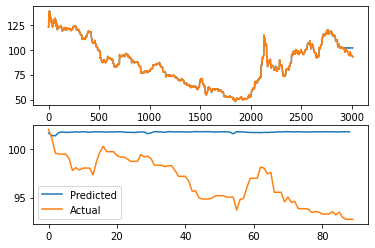

In [ ]:
plt.subplot(211)
plt.plot(df_drop['Coal_price'].values , label='Predicted')
plt.plot(df_coal['Coal_price'].values , label='Actual')


plt.subplot(212)
plt.plot(df_drop['Coal_price'][-90:].values, label='Predicted')
plt.plot(df_coal['Coal_price'][-90:].values, label='Actual')
plt.legend()
plt.show()

##2.7 recursive - 1month val

*   30개 변수 prophe prediction 값 
*   y_pred값을 validation셋에 추가

*   결과값이 좀 보여서 다른 기간내에 적용해보기




Data

*   df는 실제값으로 2018년도 12월 31일까지
*   df_pred는 prophet으로 prediction한 값 2019년부터 1월 1일까지 (Coal_price 제외)
*   df_merge에 예측에 필요한 coal_price값 제외하고 merge






In [ ]:
df = pd.read_excel("/content/gdrive/My Drive/Black_coal/data/dataset/project_dataset.xlsx")
df = df.sort_values('date')
df['date']= pd.to_datetime(df['date'])

df = df.set_index('date')
df = df[df.index < '2019-01-01']
df = df.reset_index()

In [ ]:
df_pred = pd.read_csv("/content/gdrive/My Drive/Black_coal/data/dataset/prophet_pred/prophet_pred_final.csv", encoding = 'utf-8-sig')
df_pred = df_pred.rename(columns ={'ds':'date'})
df_pred['date']= pd.to_datetime(df_pred['date'])

df_pred = df_pred.set_index('date')
df_pred = df_pred.reset_index()


In [ ]:
df_merge = pd.merge(df, df_pred, on=['date', 'Brent_fut', 'iron', 'copper_fut', 'WTI_fut', 'WTI', 'LNG_fut',
       'bdi', 'USD/AUD(호주)', 'USD/CAD(캐나다)', 'USD/COP(콜롬비아)', 'US 달러지수',
       'USD/IDR(인도네시아)', 'USD/RUB(러시아)', 'USD/ZAR(자메이카)', '상하이종합지수', '인도지수',
       '브라질지수', '다우존스지수', '프랑스지수', '영국지수', '독일지수', 'S&P500지수', '항셍지수', '나스닥지수',
       '코스피지수', '니케이225지수', '유로스톡스50지수', '호주지수', '캐나다지수'], how='outer')
       
df_merge = df_merge[['date', 'Coal_price', 'Brent_fut', 'iron', 'copper_fut', 'WTI_fut', 'WTI', 'LNG_fut',
       'bdi', 'USD/AUD(호주)', 'USD/CAD(캐나다)', 'USD/COP(콜롬비아)', 'US 달러지수',
       'USD/IDR(인도네시아)', 'USD/RUB(러시아)', 'USD/ZAR(자메이카)', '상하이종합지수', '인도지수',
       '브라질지수', '다우존스지수', '프랑스지수', '영국지수', '독일지수', 'S&P500지수', '항셍지수', '나스닥지수',
       '코스피지수', '니케이225지수', '유로스톡스50지수', '호주지수', '캐나다지수']]
df_merge['date']= pd.to_datetime(df_merge['date'])



In [ ]:
df_drop = df_merge.drop('date',axis=1)


In [ ]:
df_coal = pd.read_csv("/content/gdrive/My Drive/Black_coal/data/dataset/project_dataset.csv", encoding = 'utf-8-sig')
df_coal = df_coal.sort_values('date')
df_coal['date']= pd.to_datetime(df_coal['date'])

df_coal = df_coal.set_index('date')
df_coal = df_coal[df_coal.index < '2019-04-01']

df_coal = df_coal.reset_index()
df_coal = df_coal[['date','Coal_price']]


In [ ]:
df_merge = df_merge.set_index('date')

In [ ]:
for i in range (89):
    
  
  # 학습과 테스트 데이터 분리
  split =  len(df_merge[:"2018-11-30"])
  split1 =  len(df_merge[:"2018-12-31"])
  
  df_train = df_drop[:split+i]
  df_test = df_drop[split+i:split1+i]
  df_predict = df_drop[len(df_merge[:"2018-12-31"]):len(df_merge[:"2019-01-01"])]

  df_train_y = df_train.loc[:,'Coal_price']
  df_train_x = df_train.drop('Coal_price', axis=1)
  df_test_y = df_test.loc[:,'Coal_price']
  df_test_x = df_test.drop('Coal_price', axis=1)
  # 나중에 예측값과 비교하기 위해 test 데이터 복제본 저장
  df_test_orig = df_coal.loc[:, 'Coal_price']
  df_predict_x = df_predict.drop('Coal_price', axis=1)
  df_predict_x = df_predict_x[:]



  XG_model_month = xgb.XGBRegressor(learning_rate=0.1,max_depth=6,n_estimators=200)
  XG_model_month.fit(df_train_x, df_train_y, eval_set=[(df_test_x, df_test_y)], early_stopping_rounds=100,verbose=False)
  
  xgboost = XG_model_month.predict(df_predict_x)

  # 실제 값과 예측 값을 하나의 DataFrame으로 만들고 visualize
  result=pd.concat([df_test_orig.reset_index(), pd.DataFrame(xgboost, columns=['xgboost'])], axis=1, ignore_index=False)
  
  df_drop['Coal_price'][len(df_merge[:"2018-12-31"])+i]=result['xgboost'][0]
  # df_drop['shift'][len(df_merge[:"2019-01-01"])+i]=result['xgboost'][0]
  print(df_drop['Coal_price'][len(df_merge[:"2018-12-31"])]+i)
  # print(df_drop['shift'][len(df_merge[:"2019-01-01"])]+i)

[06:12:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
110.12329864501953
[06:12:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
111.12329864501953
[06:12:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
112.12329864501953
[06:12:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
113.12329864501953
[06:12:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
114.12329864501953
[06:12:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
115.12329864501953
[06:13:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederro

###result

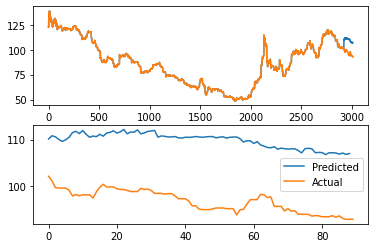

In [ ]:
plt.subplot(211)
plt.plot(df_drop['Coal_price'].values , label='Predicted')
plt.plot(df_coal['Coal_price'].values , label='Actual')


plt.subplot(212)
plt.plot(df_drop['Coal_price'][-90:].values, label='Predicted')
plt.plot(df_coal['Coal_price'][-90:].values, label='Actual')
plt.legend()
plt.show()

## 2.8 recursive - 1month val / t-1



*  t-1시점의 y데이터 추가
- recursive model






In [ ]:
df2 = pd.read_excel("/content/gdrive/My Drive/Black_coal/data/dataset/project_dataset.xlsx")
df2 = df2.sort_values('date')
df2['date']= pd.to_datetime(df2['date'])

df2 = df2.set_index('date')
df2 = df2[df2.index < '2019-01-02']
df2 = df2.reset_index()
df2 = df2[['date','Coal_price']] 
df2 = df2.rename(columns ={'date':'ds'})
shift= df2['Coal_price'].shift(1)
shift[0]=df2['Coal_price'][0]

shift2 = df2[['ds','Coal_price']]
shift2=df2.rename(columns={'Coal_price' : 'shift'})
shift2['shift']=shift


df_merge=df_merge.reset_index()
df_merge=df_merge.rename(columns={'date':'ds'})
df_merge = pd.merge(df_merge,shift2,on='ds',how='outer')
df_drop = df_merge.drop('ds',axis=1)

In [ ]:
df_merge=df_merge.set_index('ds')

In [ ]:
for i in range (89):
    
  
  # 학습과 테스트 데이터 분리
  split =  len(df_merge[:"2018-11-30"])
  split1 =  len(df_merge[:"2018-12-31"])
  
  df_train = df_drop[:split+i]
  df_test = df_drop[split+i:split1+i]
  df_predict = df_drop[len(df_merge[:"2018-12-31"]):len(df_merge[:"2019-01-01"])]

  df_train_y = df_train.loc[:,'Coal_price']
  df_train_x = df_train.drop('Coal_price', axis=1)
  df_test_y = df_test.loc[:,'Coal_price']
  df_test_x = df_test.drop('Coal_price', axis=1)
  # 나중에 예측값과 비교하기 위해 test 데이터 복제본 저장
  df_test_orig = df_coal.loc[:, 'Coal_price']
  df_predict_x = df_predict.drop('Coal_price', axis=1)
  df_predict_x = df_predict_x[:]



  XG_model_month = xgb.XGBRegressor(learning_rate=0.1,max_depth=6,n_estimators=200)
  XG_model_month.fit(df_train_x, df_train_y, eval_set=[(df_test_x, df_test_y)], early_stopping_rounds=100,verbose=False)
  
  xgboost = XG_model_month.predict(df_predict_x)

  # 실제 값과 예측 값을 하나의 DataFrame으로 만들고 visualize
  result=pd.concat([df_test_orig.reset_index(), pd.DataFrame(xgboost, columns=['xgboost'])], axis=1, ignore_index=False)
  
  df_drop['Coal_price'][len(df_merge[:"2018-12-31"])+i]=result['xgboost'][0]
  df_drop['shift'][len(df_merge[:"2019-01-01"])+i]=result['xgboost'][0]
  print(df_drop['Coal_price'][len(df_merge[:"2018-12-31"])]+i)
  print(df_drop['shift'][len(df_merge[:"2019-01-01"])]+i)

[06:15:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
101.59574127197266
101.59574127197266
[06:15:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
102.59574127197266
102.59574127197266
[06:15:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
103.59574127197266
103.59574127197266
[06:15:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
104.59574127197266
104.59574127197266
[06:15:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
105.59574127197266
105.59574127197266
[06:15:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
106.59574127197266
106.59574127197266
[06:15:46]

###result

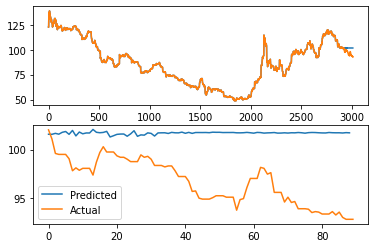

In [ ]:
plt.subplot(211)
plt.plot(df_drop['Coal_price'].values , label='Predicted')
plt.plot(df_coal['Coal_price'].values , label='Actual')


plt.subplot(212)
plt.plot(df_drop['Coal_price'][-90:].values, label='Predicted')
plt.plot(df_coal['Coal_price'][-90:].values, label='Actual')
plt.legend()
plt.show()

##2.9 recursive (1년 val- test기간 맞추기)

*   30개 변수 prophe prediction 값 
*   y_pred값을 validation셋에 추가


In [ ]:
df_merge = df_merge.set_index('date')

In [ ]:
for i in range (89):
    
  
  # 학습과 테스트 데이터 분리
  split =  len(df_merge[:"2018-12-30"])
  split1 =  len(df_merge[:"2018-12-31"])
  
  df_train = df_drop[:split+i]
  df_test = df_drop[split+i:split1+i]
  df_predict = df_drop[len(df_merge[:"2018-12-31"]):len(df_merge[:"2019-01-01"])]

  df_train_y = df_train.loc[:,'Coal_price']
  df_train_x = df_train.drop('Coal_price', axis=1)
  df_test_y = df_test.loc[:,'Coal_price']
  df_test_x = df_test.drop('Coal_price', axis=1)
  # 나중에 예측값과 비교하기 위해 test 데이터 복제본 저장
  df_test_orig = df_coal.loc[:, 'Coal_price']
  df_predict_x = df_predict.drop('Coal_price', axis=1)
  df_predict_x = df_predict_x[:]



  XG_model_month = xgb.XGBRegressor(learning_rate=0.1,max_depth=6,n_estimators=200)
  XG_model_month.fit(df_train_x, df_train_y, eval_set=[(df_test_x, df_test_y)], early_stopping_rounds=100,verbose=False)
  
  xgboost = XG_model_month.predict(df_predict_x)

  # 실제 값과 예측 값을 하나의 DataFrame으로 만들고 visualize
  result=pd.concat([df_test_orig.reset_index(), pd.DataFrame(xgboost, columns=['xgboost'])], axis=1, ignore_index=False)
  
  df_drop['Coal_price'][len(df_merge[:"2018-12-31"])+i]=result['xgboost'][0]
  # df_drop['shift'][len(df_merge[:"2019-01-01"])+i]=result['xgboost'][0]
  print(df_drop['Coal_price'][len(df_merge[:"2018-12-31"])]+i)
  # print(df_drop['shift'][len(df_merge[:"2019-01-01"])]+i)

[23:45:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
111.50236511230469
[23:45:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
112.50236511230469
[23:45:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
113.50236511230469
[23:45:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
114.50236511230469
[23:45:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
115.50236511230469
[23:46:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
116.50236511230469
[23:46:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederro

###result

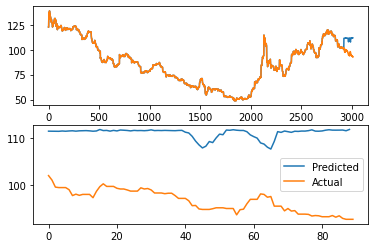

In [ ]:
plt.subplot(211)
plt.plot(df_drop['Coal_price'].values , label='Predicted')
plt.plot(df_coal['Coal_price'].values , label='Actual')


plt.subplot(212)
plt.plot(df_drop['Coal_price'][-90:].values, label='Predicted')
plt.plot(df_coal['Coal_price'][-90:].values, label='Actual')
plt.legend()
plt.show()

##2.10 recursive / (t-1Coal_price)



*  t-1시점의 y데이터 추가
- recursive model






In [ ]:
df2 = pd.read_excel("/content/gdrive/My Drive/Black_coal/data/dataset/project_dataset.xlsx")
df2 = df2.sort_values('date')
df2['date']= pd.to_datetime(df2['date'])

df2 = df2.set_index('date')
df2 = df2[df2.index < '2019-01-02']
df2 = df2.reset_index()
df2 = df2[['date','Coal_price']] 
df2 = df2.rename(columns ={'date':'ds'})
shift= df2['Coal_price'].shift(1)
shift[0]=df2['Coal_price'][0]

shift2 = df2[['ds','Coal_price']]
shift2=df2.rename(columns={'Coal_price' : 'shift'})
shift2['shift']=shift
shift2



,ds,shift
0,2011-01-01,122.65
1,2011-01-02,122.65
2,2011-01-03,122.65
3,2011-01-04,136.50
4,2011-01-05,137.30
...,...,...
2918,2018-12-28,101.55
2919,2018-12-29,101.90
2920,2018-12-30,101.90
2921,2018-12-31,101.90


In [ ]:
df_merge=df_merge.reset_index()

In [ ]:
df_merge=df_merge.rename(columns={'date':'ds'})
df_merge

,ds,Coal_price,Brent_fut,iron,copper_fut,WTI_fut,WTI,LNG_fut,bdi,USD/AUD(호주),...,영국지수,독일지수,S&P500지수,항셍지수,나스닥지수,코스피지수,니케이225지수,유로스톡스50지수,호주지수,캐나다지수
0,2011-01-01,122.65,94.750000,168.300000,9644.000000,91.380000,91.400000,61.070000,1773.000000,0.984470,...,5899.899902,6914.189941,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039,4745.200195,13443.200195
1,2011-01-02,122.65,94.750000,168.300000,9644.000000,91.380000,91.400000,61.070000,1773.000000,0.984470,...,5899.899902,6914.189941,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039,4745.200195,13443.200195
2,2011-01-03,136.50,94.840000,170.000000,9644.000000,91.550000,91.560000,61.070000,1773.000000,0.979010,...,5899.899902,6989.740234,1271.869995,23436.050781,2691.520020,2070.080078,10228.919922,2839.429932,4745.200195,13443.200195
3,2011-01-04,137.30,93.530000,172.100000,9619.250000,89.380000,89.230000,58.320000,1693.000000,0.983370,...,6013.899902,6975.350098,1270.199951,23668.480469,2681.250000,2085.139893,10398.099609,2844.169922,4742.500000,13402.299805
4,2011-01-05,130.65,95.500000,174.500000,9586.000000,90.300000,90.380000,56.400000,1621.000000,0.992850,...,6043.899902,6939.819824,1276.560059,23757.820312,2702.199951,2082.550049,10380.769531,2833.739990,4714.899902,13396.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3007,2019-03-27,NaN,84.124730,72.446181,6703.428741,74.566090,74.733597,71.442419,1402.027680,1.372171,...,7298.123222,11897.295010,2918.493060,29237.210404,8123.580208,2252.528334,23546.358166,3263.093898,6171.147374,15954.943396
3008,2019-03-28,NaN,84.199753,72.354536,6691.270487,74.562116,74.750119,71.307777,1399.854283,1.373349,...,7290.969546,11893.885654,2919.238593,29209.282776,8123.496620,2252.020118,23542.239644,3261.886242,6175.229169,15943.334716
3009,2019-03-29,NaN,84.291781,72.370737,6683.270496,74.628844,74.817677,71.206234,1396.475330,1.374941,...,7287.452489,11888.538235,2919.920821,29195.805869,8122.842283,2249.926048,23541.187552,3259.948145,6176.074040,15927.833254
3010,2019-03-30,NaN,84.363165,72.375087,6673.171699,74.731828,74.938001,71.049927,1390.815421,1.376403,...,7283.986305,11884.435037,2920.547457,29173.373865,8122.769151,2247.524109,23537.235686,3257.373048,6176.594855,15915.512454


In [ ]:
df_merge = pd.merge(df_merge,shift2,on='ds',how='outer')
df_merge

,ds,Coal_price,Brent_fut,iron,copper_fut,WTI_fut,WTI,LNG_fut,bdi,USD/AUD(호주),...,독일지수,S&P500지수,항셍지수,나스닥지수,코스피지수,니케이225지수,유로스톡스50지수,호주지수,캐나다지수,shift
0,2011-01-01,122.65,94.750000,168.300000,9644.000000,91.380000,91.400000,61.070000,1773.000000,0.984470,...,6914.189941,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039,4745.200195,13443.200195,122.65
1,2011-01-02,122.65,94.750000,168.300000,9644.000000,91.380000,91.400000,61.070000,1773.000000,0.984470,...,6914.189941,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039,4745.200195,13443.200195,122.65
2,2011-01-03,136.50,94.840000,170.000000,9644.000000,91.550000,91.560000,61.070000,1773.000000,0.979010,...,6989.740234,1271.869995,23436.050781,2691.520020,2070.080078,10228.919922,2839.429932,4745.200195,13443.200195,122.65
3,2011-01-04,137.30,93.530000,172.100000,9619.250000,89.380000,89.230000,58.320000,1693.000000,0.983370,...,6975.350098,1270.199951,23668.480469,2681.250000,2085.139893,10398.099609,2844.169922,4742.500000,13402.299805,136.50
4,2011-01-05,130.65,95.500000,174.500000,9586.000000,90.300000,90.380000,56.400000,1621.000000,0.992850,...,6939.819824,1276.560059,23757.820312,2702.199951,2082.550049,10380.769531,2833.739990,4714.899902,13396.000000,137.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3007,2019-03-27,NaN,84.124730,72.446181,6703.428741,74.566090,74.733597,71.442419,1402.027680,1.372171,...,11897.295010,2918.493060,29237.210404,8123.580208,2252.528334,23546.358166,3263.093898,6171.147374,15954.943396,NaN
3008,2019-03-28,NaN,84.199753,72.354536,6691.270487,74.562116,74.750119,71.307777,1399.854283,1.373349,...,11893.885654,2919.238593,29209.282776,8123.496620,2252.020118,23542.239644,3261.886242,6175.229169,15943.334716,NaN
3009,2019-03-29,NaN,84.291781,72.370737,6683.270496,74.628844,74.817677,71.206234,1396.475330,1.374941,...,11888.538235,2919.920821,29195.805869,8122.842283,2249.926048,23541.187552,3259.948145,6176.074040,15927.833254,NaN
3010,2019-03-30,NaN,84.363165,72.375087,6673.171699,74.731828,74.938001,71.049927,1390.815421,1.376403,...,11884.435037,2920.547457,29173.373865,8122.769151,2247.524109,23537.235686,3257.373048,6176.594855,15915.512454,NaN


In [ ]:
df_drop = df_merge.drop('ds',axis=1)

In [ ]:
df_merge=df_merge.set_index('ds')

In [ ]:
for i in range (89):
    
  
  # 학습과 테스트 데이터 분리
  split =  len(df_merge[:"2018-12-30"])
  split1 =  len(df_merge[:"2018-12-31"])
  
  df_train = df_drop[:split+i]
  df_test = df_drop[split+i:split1+i]
  df_predict = df_drop[len(df_merge[:"2018-12-31"]):len(df_merge[:"2019-01-01"])]

  df_train_y = df_train.loc[:,'Coal_price']
  df_train_x = df_train.drop('Coal_price', axis=1)
  df_test_y = df_test.loc[:,'Coal_price']
  df_test_x = df_test.drop('Coal_price', axis=1)
  # 나중에 예측값과 비교하기 위해 test 데이터 복제본 저장
  df_test_orig = df_coal.loc[:, 'Coal_price']
  df_predict_x = df_predict.drop('Coal_price', axis=1)
  df_predict_x = df_predict_x[:]



  XG_model_month = xgb.XGBRegressor(learning_rate=0.1,max_depth=6,n_estimators=200)
  XG_model_month.fit(df_train_x, df_train_y, eval_set=[(df_test_x, df_test_y)], early_stopping_rounds=100,verbose=False)
  
  xgboost = XG_model_month.predict(df_predict_x)

  # 실제 값과 예측 값을 하나의 DataFrame으로 만들고 visualize
  result=pd.concat([df_test_orig.reset_index(), pd.DataFrame(xgboost, columns=['xgboost'])], axis=1, ignore_index=False)
  
  df_drop['Coal_price'][len(df_merge[:"2018-12-31"])+i]=result['xgboost'][0]
  df_drop['shift'][len(df_merge[:"2019-01-01"])+i]=result['xgboost'][0]
  print(df_drop['Coal_price'][len(df_merge[:"2018-12-31"])]+i)
  print(df_drop['shift'][len(df_merge[:"2019-01-01"])]+i)

[23:49:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
101.67930603027344
101.67930603027344
[23:49:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
102.67930603027344
102.67930603027344
[23:49:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
103.67930603027344
103.67930603027344
[23:49:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
104.67930603027344
104.67930603027344
[23:49:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
105.67930603027344
105.67930603027344
[23:49:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
106.67930603027344
106.67930603027344
[23:50:00]

###result

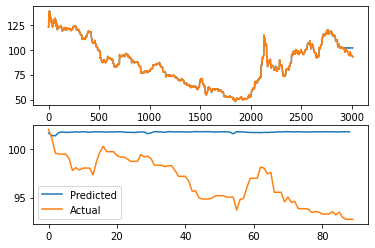

In [ ]:
plt.subplot(211)
plt.plot(df_drop['Coal_price'].values , label='Predicted')
plt.plot(df_coal['Coal_price'].values , label='Actual')


plt.subplot(212)
plt.plot(df_drop['Coal_price'][-90:].values, label='Predicted')
plt.plot(df_coal['Coal_price'][-90:].values, label='Actual')
plt.legend()
plt.show()

#3.(prophet+xgboost)

*   df는 실제값으로 2018년도 12월 31일까지
*   df_pred는 prophet으로 prediction한 값 2019년부터 1월 1일까지 (Coal_price 제외)







In [ ]:
df = pd.read_excel("/content/gdrive/My Drive/Black_coal/data/dataset/project_dataset.xlsx")
df = df.sort_values('date')
df['date']= pd.to_datetime(df['date'])

df = df.set_index('date')
df = df[df.index < '2019-01-01']
df = df.reset_index()
df_pred = pd.read_csv("/content/gdrive/My Drive/Black_coal/data/dataset/prophet_pred/prophet_pred_final.csv", encoding = 'utf-8-sig')
df_pred = df_pred.rename(columns ={'ds':'date'})
df_pred['date']= pd.to_datetime(df_pred['date'])

df_pred = df_pred.set_index('date')
df_pred = df_pred.reset_index()
df_merge = pd.merge(df, df_pred, on=['date', 'Brent_fut', 'iron', 'copper_fut', 'WTI_fut', 'WTI', 'LNG_fut',
       'bdi', 'USD/AUD(호주)', 'USD/CAD(캐나다)', 'USD/COP(콜롬비아)', 'US 달러지수',
       'USD/IDR(인도네시아)', 'USD/RUB(러시아)', 'USD/ZAR(자메이카)', '상하이종합지수', '인도지수',
       '브라질지수', '다우존스지수', '프랑스지수', '영국지수', '독일지수', 'S&P500지수', '항셍지수', '나스닥지수',
       '코스피지수', '니케이225지수', '유로스톡스50지수', '호주지수', '캐나다지수'], how='outer')
       
df_merge = df_merge[['date', 'Coal_price', 'Brent_fut', 'iron', 'copper_fut', 'WTI_fut', 'WTI', 'LNG_fut',
       'bdi', 'USD/AUD(호주)', 'USD/CAD(캐나다)', 'USD/COP(콜롬비아)', 'US 달러지수',
       'USD/IDR(인도네시아)', 'USD/RUB(러시아)', 'USD/ZAR(자메이카)', '상하이종합지수', '인도지수',
       '브라질지수', '다우존스지수', '프랑스지수', '영국지수', '독일지수', 'S&P500지수', '항셍지수', '나스닥지수',
       '코스피지수', '니케이225지수', '유로스톡스50지수', '호주지수', '캐나다지수']]
df_merge['date']= pd.to_datetime(df_merge['date'])
df_coal = pd.read_csv("/content/gdrive/My Drive/Black_coal/data/dataset/project_dataset.csv", encoding = 'utf-8-sig')
df_coal = df_coal.sort_values('date')
df_coal['date']= pd.to_datetime(df_coal['date'])

df_coal = df_coal.set_index('date')
df_coal = df_coal[df_coal.index < '2019-04-01']


df_coal = df_coal.reset_index()
df_coal = df_coal[['date','Coal_price']]
df_merge=df_merge.set_index('date')

In [ ]:

# 학습과 테스트 데이터 분리
split =  "2017-12-31"
split1 =  "2018-12-31"

df_train = df_merge[:split]
df_test = df_merge[split:split1]
df_predict = df_merge["2019-01-01":"2019-03-31"]

df_train_y = df_train.loc[:,'Coal_price']
df_train_x = df_train.drop('Coal_price', axis=1)
df_test_y = df_test.loc[:,'Coal_price']
df_test_x = df_test.drop('Coal_price', axis=1)
# 나중에 예측값과 비교하기 위해 test 데이터 복제본 저장
df_test_orig = df_coal.loc[:, 'Coal_price']
df_predict_x = df_predict.drop('Coal_price', axis=1)
df_predict_x = df_predict_x[:]


[06:18:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


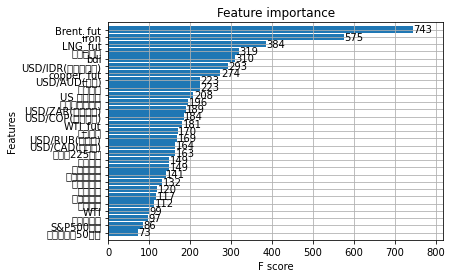

In [ ]:
XG_model_month = xgb.XGBRegressor(learning_rate=0.1,max_depth=6,n_estimators=200)
XG_model_month.fit(df_train_x, df_train_y, eval_set=[(df_test_x, df_test_y)], early_stopping_rounds=100,verbose=False)

# 주요하게 적용하는 변수를 판단
plot_importance(XG_model_month, height=0.9)

###result

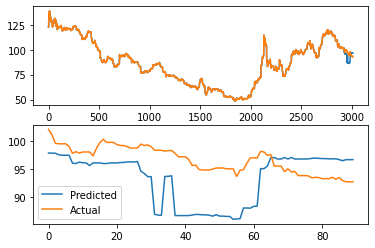

In [ ]:
# 테스트 데이터 중 특정 store/item 데이터를 추출


xgboost = XG_model_month.predict(df_predict_x)

# 실제 값과 예측 값을 하나의 DataFrame으로 만들고 visualize
result=pd.concat([df_test_orig.reset_index(), pd.DataFrame(xgboost, columns=['xgboost'])], axis=1, ignore_index=False)
# result = result.set_index('date')
result = result.loc[:, ['Coal_price', 'xgboost']]

df_con=pd.concat([df_train['Coal_price'],df_test['Coal_price']],axis=0)
df_con=pd.concat([df_con,result['xgboost']],axis=0)
con = pd.DataFrame(df_con)

plt.subplot(211)
plt.plot(con.values , label='Predicted')
plt.plot(df_coal['Coal_price'].values , label='Actual')


plt.subplot(212)
plt.plot(result['xgboost'].values, label='Predicted')
plt.plot(df_coal['Coal_price'][-90:].values, label='Actual')
plt.legend()
plt.show()

Max_depth 20

[06:18:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


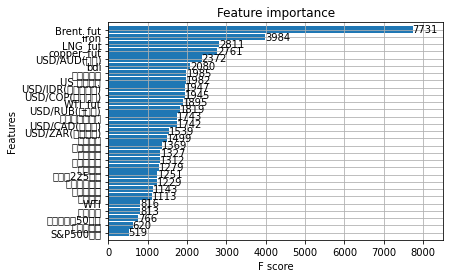

In [ ]:
XG_model_month = xgb.XGBRegressor(n_estimators=1000, max_depth= 20)
XG_model_month.fit(df_train_x, df_train_y, eval_set=[(df_test_x, df_test_y)], early_stopping_rounds=100,verbose=False)

# 주요하게 적용하는 변수를 판단
plot_importance(XG_model_month, height=0.9)

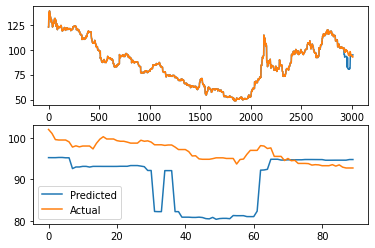

In [ ]:
# 테스트 데이터 중 특정 store/item 데이터를 추출


xgboost = XG_model_month.predict(df_predict_x)

# 실제 값과 예측 값을 하나의 DataFrame으로 만들고 visualize
result=pd.concat([df_test_orig.reset_index(), pd.DataFrame(xgboost, columns=['xgboost'])], axis=1, ignore_index=False)
# result = result.set_index('date')
result = result.loc[:, ['Coal_price', 'xgboost']]

df_con=pd.concat([df_train['Coal_price'],df_test['Coal_price']],axis=0)
df_con=pd.concat([df_con,result['xgboost']],axis=0)
con = pd.DataFrame(df_con)

plt.subplot(211)
plt.plot(con.values , label='Predicted')
plt.plot(df_coal['Coal_price'].values , label='Actual')


plt.subplot(212)
plt.plot(result['xgboost'].values, label='Predicted')
plt.plot(df_coal['Coal_price'][-90:].values, label='Actual')
plt.legend()
plt.show()

Max_depth 30

[06:18:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


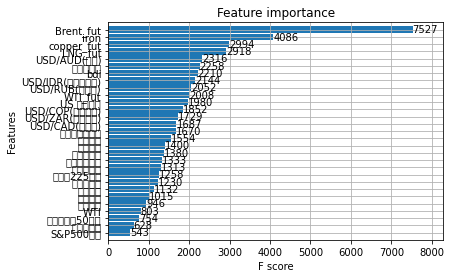

In [ ]:
XG_model_month = xgb.XGBRegressor(n_estimators=1000, max_depth= 30)
XG_model_month.fit(df_train_x, df_train_y, eval_set=[(df_test_x, df_test_y)], early_stopping_rounds=100,verbose=False)

# 주요하게 적용하는 변수를 판단
plot_importance(XG_model_month, height=0.9)

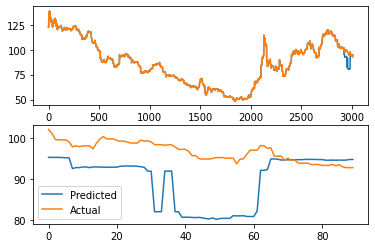

In [ ]:
# 테스트 데이터 중 특정 store/item 데이터를 추출


xgboost = XG_model_month.predict(df_predict_x)

# 실제 값과 예측 값을 하나의 DataFrame으로 만들고 visualize
result=pd.concat([df_test_orig.reset_index(), pd.DataFrame(xgboost, columns=['xgboost'])], axis=1, ignore_index=False)
# result = result.set_index('date')
result = result.loc[:, ['Coal_price', 'xgboost']]

df_con=pd.concat([df_train['Coal_price'],df_test['Coal_price']],axis=0)
df_con=pd.concat([df_con,result['xgboost']],axis=0)
con = pd.DataFrame(df_con)

plt.subplot(211)
plt.plot(con.values , label='Predicted')
plt.plot(df_coal['Coal_price'].values , label='Actual')


plt.subplot(212)
plt.plot(result['xgboost'].values, label='Predicted')
plt.plot(df_coal['Coal_price'][-90:].values, label='Actual')
plt.legend()
plt.show()

#4.(feature true 값- xgboost)

*   df는 실제값으로 2018년도 12월 31일까지
*   df_pred는 prophet으로 prediction한 값 2019년부터 1월 1일까지 (Coal_price 제외)







In [ ]:
df = pd.read_excel("/content/gdrive/My Drive/Black_coal/data/dataset/project_dataset.xlsx")
df = df.sort_values('date')
df['date']= pd.to_datetime(df['date'])

df = df.set_index('date')
df = df[df.index < '2019-04-01']
df = df.reset_index()
df = df.drop('Coal_price',axis=1)

df_coal = pd.read_csv("/content/gdrive/My Drive/Black_coal/data/dataset/project_dataset.csv", encoding = 'utf-8-sig')
df_coal = df_coal.sort_values('date')
df_coal['date']= pd.to_datetime(df_coal['date'])

df_coal = df_coal.set_index('date')
df_coal = df_coal[df_coal.index <'2019-01-01']

df_coal = df_coal.reset_index()
df_coal = df_coal[['date','Coal_price']]

In [ ]:
df_merge=pd.merge(df_coal,df, how='right')
df_merge

,date,Coal_price,iron,Brent_fut,copper_fut,WTI_fut,WTI,LNG_fut,bdi,USD/AUD(호주),...,영국지수,독일지수,S&P500지수,항셍지수,나스닥지수,코스피지수,니케이225지수,유로스톡스50지수,호주지수,캐나다지수
0,2011-01-01,122.65,168.30,94.75,9644.00,91.38,91.40,61.07,1773.0,0.98447,...,5899.899902,6914.189941,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039,4745.200195,13443.200195
1,2011-01-02,122.65,168.30,94.75,9644.00,91.38,91.40,61.07,1773.0,0.98447,...,5899.899902,6914.189941,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039,4745.200195,13443.200195
2,2011-01-03,136.50,170.00,94.84,9644.00,91.55,91.56,61.07,1773.0,0.97901,...,5899.899902,6989.740234,1271.869995,23436.050781,2691.520020,2070.080078,10228.919922,2839.429932,4745.200195,13443.200195
3,2011-01-04,137.30,172.10,93.53,9619.25,89.38,89.23,58.32,1693.0,0.98337,...,6013.899902,6975.350098,1270.199951,23668.480469,2681.250000,2085.139893,10398.099609,2844.169922,4742.500000,13402.299805
4,2011-01-05,130.65,174.50,95.50,9586.00,90.30,90.38,56.40,1621.0,0.99285,...,6043.899902,6939.819824,1276.560059,23757.820312,2702.199951,2082.550049,10380.769531,2833.739990,4714.899902,13396.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3007,2019-03-27,NaN,85.72,67.83,6336.00,59.41,59.12,37.47,690.0,1.40115,...,7194.200195,11419.040039,2805.370117,28728.250000,7643.379883,2145.620117,21378.730469,3322.040039,6136.000000,16132.500000
3008,2019-03-28,NaN,85.64,67.82,6368.75,59.30,59.30,36.05,692.0,1.41153,...,7234.299805,11428.160156,2815.439941,28775.210938,7669.169922,2128.100098,21033.759766,3320.290039,6176.100098,16155.500000
3009,2019-03-29,NaN,85.70,68.39,6475.75,60.14,59.98,34.61,689.0,1.41180,...,7279.200195,11526.040039,2834.399902,29051.359375,7729.319824,2140.669922,21205.810547,3351.709961,6180.700195,16102.099609
3010,2019-03-30,NaN,85.70,68.39,6475.75,60.14,59.98,34.61,689.0,1.41180,...,7279.200195,11526.040039,2834.399902,29051.359375,7729.319824,2140.669922,21205.810547,3351.709961,6180.700195,16102.099609


In [ ]:
df_merge=df_merge.set_index('date')

In [ ]:
split =  "2018-12-31"
split1 =  "2019-04-01"

df_merge[split:split1]

,Coal_price,iron,Brent_fut,copper_fut,WTI_fut,WTI,LNG_fut,bdi,USD/AUD(호주),USD/CAD(캐나다),...,영국지수,독일지수,S&P500지수,항셍지수,나스닥지수,코스피지수,니케이225지수,유로스톡스50지수,호주지수,캐나다지수
date,,,,,,,,,,,,,,,,,,,,,
2018-12-31,102.05,69.20,53.80,5981.00,45.41,45.00,61.07,1271.0,1.41950,1.36220,...,6728.100098,10558.959961,2506.850098,25845.699219,6635.279785,2041.040039,20014.769531,2986.530029,5646.399902,14322.900391
2019-01-01,NaN,69.20,53.80,5981.00,45.89,45.00,61.07,1271.0,1.42010,1.33943,...,6728.100098,10558.959961,2506.850098,25845.699219,6635.279785,2041.040039,20014.769531,2986.530029,5646.399902,14322.900391
2019-01-02,NaN,71.06,54.91,5871.25,46.54,45.66,62.16,1282.0,1.41886,1.36254,...,6734.200195,10580.190430,2510.030029,25130.349609,6665.939941,2010.000000,20014.769531,2986.530029,5557.799805,14347.200195
2019-01-03,NaN,72.23,55.95,5778.50,47.09,46.78,61.81,1267.0,1.44530,1.36312,...,6692.700195,10416.660156,2447.889893,25064.359375,6463.500000,1993.699951,20014.769531,2954.659912,5633.399902,14212.799805
2019-01-04,NaN,73.09,57.06,5933.75,47.96,48.18,63.55,1260.0,1.42730,1.34788,...,6837.399902,10767.690430,2531.939941,25626.029297,6738.859863,2010.250000,19561.960938,3041.850098,5619.399902,14426.599609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-03-27,NaN,85.72,67.83,6336.00,59.41,59.12,37.47,690.0,1.40115,1.33791,...,7194.200195,11419.040039,2805.370117,28728.250000,7643.379883,2145.620117,21378.730469,3322.040039,6136.000000,16132.500000
2019-03-28,NaN,85.64,67.82,6368.75,59.30,59.30,36.05,692.0,1.41153,1.34117,...,7234.299805,11428.160156,2815.439941,28775.210938,7669.169922,2128.100098,21033.759766,3320.290039,6176.100098,16155.500000
2019-03-29,NaN,85.70,68.39,6475.75,60.14,59.98,34.61,689.0,1.41180,1.34305,...,7279.200195,11526.040039,2834.399902,29051.359375,7729.319824,2140.669922,21205.810547,3351.709961,6180.700195,16102.099609


In [ ]:

# 학습과 테스트 데이터 분리
split =  "2018-12-31"
split1 =  "2019-04-01"

df_train = df_merge[:split]
df_test = df_merge[split:split1]
df_predict = df_merge["2019-01-01":"2019-03-31"]

df_train_y = df_train.loc[:,'Coal_price']
df_train_x = df_train.drop('Coal_price', axis=1)
df_test_y = df_test.loc[:,'Coal_price']
df_test_x = df_test.drop('Coal_price', axis=1)
# 나중에 예측값과 비교하기 위해 test 데이터 복제본 저장
df_test_orig = df_coal.loc[:, 'Coal_price']
df_predict_x = df_predict.drop('Coal_price', axis=1)
df_predict_x = df_predict_x[:]


[06:19:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


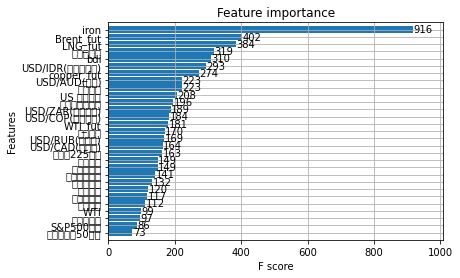

In [ ]:
XG_model_month = xgb.XGBRegressor(learning_rate=0.1,max_depth=6,n_estimators=200)
XG_model_month.fit(df_train_x, df_train_y, eval_set=[(df_test_x, df_test_y)], early_stopping_rounds=100,verbose=False)

# 주요하게 적용하는 변수를 판단
plot_importance(XG_model_month, height=0.9)

###result

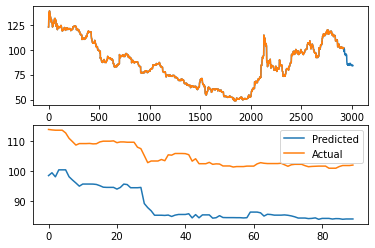

In [ ]:
# 테스트 데이터 중 특정 store/item 데이터를 추출


xgboost = XG_model_month.predict(df_predict_x)

# 실제 값과 예측 값을 하나의 DataFrame으로 만들고 visualize
result=pd.concat([df_test_orig.reset_index(), pd.DataFrame(xgboost, columns=['xgboost'])], axis=1, ignore_index=False)
# result = result.set_index('date')
result = result.loc[:, ['Coal_price', 'xgboost']]

df_con=pd.concat([df_train['Coal_price'],df_test['Coal_price']],axis=0)
df_con=pd.concat([df_con,result['xgboost']],axis=0)
con = pd.DataFrame(df_con)

plt.subplot(211)
plt.plot(con.values , label='Predicted')
plt.plot(df_coal['Coal_price'].values , label='Actual')


plt.subplot(212)
plt.plot(result['xgboost'].values, label='Predicted')
plt.plot(df_coal['Coal_price'][-90:].values, label='Actual')
plt.legend()
plt.show()

Max_depth 20

[06:19:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


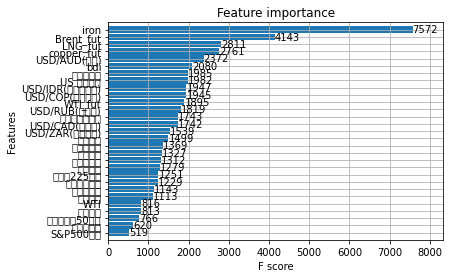

In [ ]:
XG_model_month = xgb.XGBRegressor(n_estimators=1000, max_depth= 20)
XG_model_month.fit(df_train_x, df_train_y, eval_set=[(df_test_x, df_test_y)], early_stopping_rounds=100,verbose=False)

# 주요하게 적용하는 변수를 판단
plot_importance(XG_model_month, height=0.9)

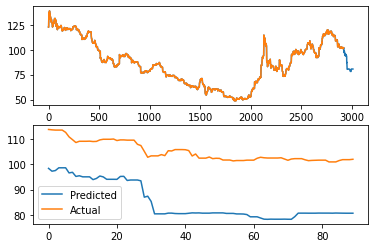

In [ ]:
# 테스트 데이터 중 특정 store/item 데이터를 추출


xgboost = XG_model_month.predict(df_predict_x)

# 실제 값과 예측 값을 하나의 DataFrame으로 만들고 visualize
result=pd.concat([df_test_orig.reset_index(), pd.DataFrame(xgboost, columns=['xgboost'])], axis=1, ignore_index=False)
# result = result.set_index('date')
result = result.loc[:, ['Coal_price', 'xgboost']]

df_con=pd.concat([df_train['Coal_price'],df_test['Coal_price']],axis=0)
df_con=pd.concat([df_con,result['xgboost']],axis=0)
con = pd.DataFrame(df_con)

plt.subplot(211)
plt.plot(con.values , label='Predicted')
plt.plot(df_coal['Coal_price'].values , label='Actual')


plt.subplot(212)
plt.plot(result['xgboost'].values, label='Predicted')
plt.plot(df_coal['Coal_price'][-90:].values, label='Actual')
plt.legend()
plt.show()

Max_depth 30

[06:19:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


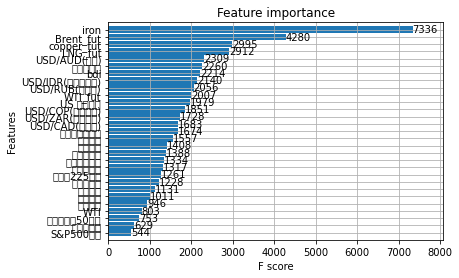

In [ ]:
XG_model_month = xgb.XGBRegressor(n_estimators=1000, max_depth= 30)
XG_model_month.fit(df_train_x, df_train_y, eval_set=[(df_test_x, df_test_y)], early_stopping_rounds=100,verbose=False)

# 주요하게 적용하는 변수를 판단
plot_importance(XG_model_month, height=0.9)

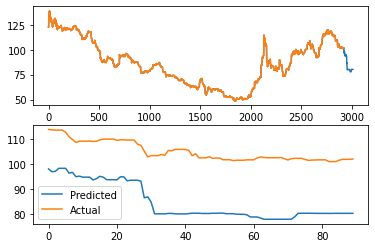

In [ ]:
# 테스트 데이터 중 특정 store/item 데이터를 추출


xgboost = XG_model_month.predict(df_predict_x)

# 실제 값과 예측 값을 하나의 DataFrame으로 만들고 visualize
result=pd.concat([df_test_orig.reset_index(), pd.DataFrame(xgboost, columns=['xgboost'])], axis=1, ignore_index=False)
# result = result.set_index('date')
result = result.loc[:, ['Coal_price', 'xgboost']]

df_con=pd.concat([df_train['Coal_price'],df_test['Coal_price']],axis=0)
df_con=pd.concat([df_con,result['xgboost']],axis=0)
con = pd.DataFrame(df_con)

plt.subplot(211)
plt.plot(con.values , label='Predicted')
plt.plot(df_coal['Coal_price'].values , label='Actual')


plt.subplot(212)
plt.plot(result['xgboost'].values, label='Predicted')
plt.plot(df_coal['Coal_price'][-90:].values, label='Actual')
plt.legend()
plt.show()